## Importance sampling (plots only - code is in fortran)

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import numexpr as ne
from math import pi

In [61]:
n = np.loadtxt("importance_sampling_exp.dat")[:,0]
err1 = np.loadtxt("importance_sampling_unif.dat")[:,3]
err2 = np.loadtxt("importance_sampling_exp.dat")[:,3]
savepath = "C:/Nicola/universita/Data_science/Labfisicacomputazionale/Assignment1/"

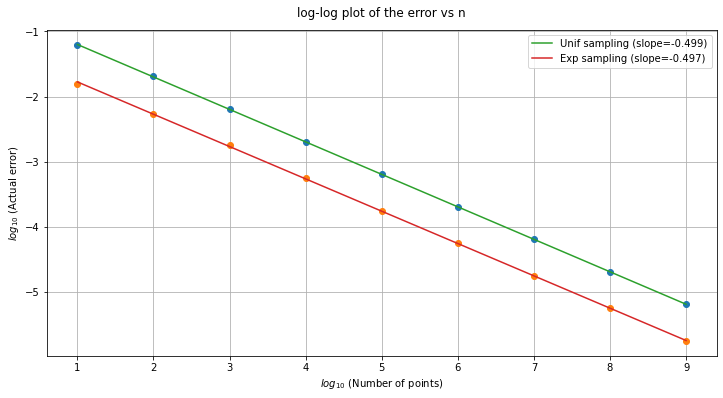

In [62]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.log10(n), np.log10(err1), 'o')
ax.plot(np.log10(n), np.log10(err2), 'o')

# Fit a line to the data
n = np.array(n).reshape(-1, 1)
reg1 = LinearRegression().fit(np.log10(n), np.log10(err1))
slope = reg1.coef_[0]
intercept = reg1.intercept_
x1 = np.log10(n)
y1 = slope * x1 + intercept
ax.plot(x1, y1, label = f"Unif sampling (slope={round(slope, 3)})")
reg2 = LinearRegression().fit(np.log10(n), np.log10(err2))
slope = reg2.coef_[0]
intercept = reg2.intercept_
y2 = slope * x1 + intercept
ax.plot(x1, y2, label = f"Exp sampling (slope={round(slope, 3)})")
ax.legend(loc='upper right')
ax.set_xlabel("$log_{10}$ (Number of points)")
ax.set_ylabel("$log_{10}$ (Actual error)")
ax.set_title(f"log-log plot of the error vs n", x=0.5, y=1.02)
ax.grid()
fig.tight_layout
fig.set_facecolor('white')
fig.savefig(savepath + "mc_importance_sampling.png", dpi=300, bbox_inches="tight")
fig.savefig(savepath + "mc_importance_sampling.pdf", dpi=300, bbox_inches="tight")
plt.show()

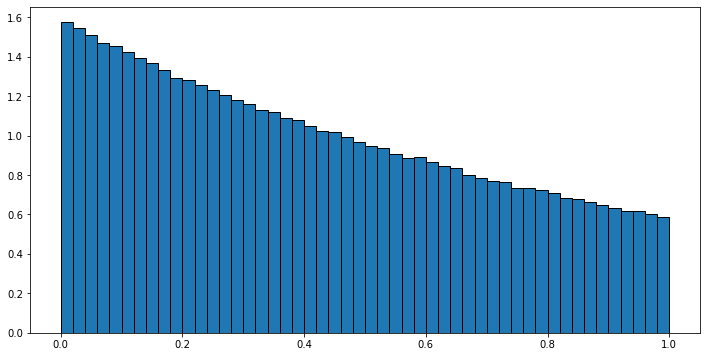

slope: -1.0029


In [63]:
x = np.loadtxt("expdev.dat")[:,0]
y = np.loadtxt("expdev.dat")[:,1]
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.bar(x, y, width=1./len(x), edgecolor="black")
plt.show()

x = x.reshape(-1, 1)
reg = LinearRegression().fit(x, np.log(y))
print ('slope:', round(reg.coef_[0], 4))

## Monte carlo method - sample mean (generic); error analysis using the "average of the averages" and the "block average"

(a) Write a code to estimate the same integral of previous exercises, $$\pi = 4I$$ with
    $$I = \int_0^1 \sqrt{1-x^2} dx $$
    
Using the MC method of sample mean with uniformly distributed random points. Evaluate the error.

In [64]:
def monte_carlo(n, fix_seed=False, variance=False, block_avg=False):
    """
    Monte Carlo simulation to estimate the value of an integral.
    
    Parameters:
    n (int): number of samples to use in the simulation.
    fix_seed (bool): if True, fix the seed for each run. Default is False.
    
    Returns:
    if block_avg:
        numpy array: the values of the function evaluated on the sampled points
    elif variance:
        tuple: a tuple containing the estimated value of the integral and its square.
    else:
        float: the estimated value of the integral
    """
    rng = np.random.default_rng()
    if fix_seed:
        rng = np.random.default_rng(n)
    x = rng.uniform(0, 1, n)
    arg = ne.evaluate('1 - x**2')
    if block_avg: # don't do it if it's not needed
        return ne.evaluate('sqrt(arg)')
    total = ne.evaluate('sum(sqrt(arg))')
    
    if variance: # evaluate total_2 only if needed (efficiency)
        total_2 = ne.evaluate('sum(arg)')
        return total / n, np.sqrt(total_2 / n - (total / n)**2)
    return total / n

In [65]:
def run_monte_carlo(n_values, exact_value, profile=False, fix_seed=False):
    """
    Run Monte Carlo simulation for different values of n and estimate the value of an integral.
    
    Parameters:
    n_values (list): a list of values of n to use in the simulation.
    profile (bool): if True, profile the code with %timeit. Default is False.
    
    Returns:
    list: a list containing the errors for each value of n.
    """

    errors = []
    for n in n_values:
        if profile:
            get_ipython().run_line_magic('timeit', 'monte_carlo(n)')
        estimate = monte_carlo(n)
        error = abs(estimate - exact_value)
        errors.append(error)
        if not profile:
            print(f"n={n}, estimate={estimate:.8f}, err={error:.8f}")
    
    return errors

In [66]:
print("Number of threads: ", ne.nthreads)
exact_value = pi / 4
print("Exact value: ", exact_value)
n_values = [int(10**(0.5*i)) for i in range(2,17)]
errors = run_monte_carlo(n_values, exact_value)#, profile=True)

Number of threads:  4
Exact value:  0.7853981633974483
n=10, estimate=0.74243523, err=0.04296293
n=31, estimate=0.82917630, err=0.04377814
n=100, estimate=0.80367169, err=0.01827353
n=316, estimate=0.76476846, err=0.02062970
n=1000, estimate=0.78898914, err=0.00359098
n=3162, estimate=0.78657709, err=0.00117893
n=10000, estimate=0.78651756, err=0.00111940
n=31622, estimate=0.78432983, err=0.00106833
n=100000, estimate=0.78548139, err=0.00008323
n=316227, estimate=0.78533869, err=0.00005947
n=1000000, estimate=0.78583734, err=0.00043918
n=3162277, estimate=0.78562838, err=0.00023022
n=10000000, estimate=0.78550704, err=0.00010888
n=31622776, estimate=0.78537876, err=0.00001940
n=100000000, estimate=0.78538753, err=0.00001064


The error should have a $1/\sqrt{n}$ behaviour: we can fit the loglog plot of the error versus n, it should have a slope of -0.5

In [67]:
def plot_error(n_values, errors, savepath):
    """
    plotting time :D
    """
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.log10(n_values), np.log10(errors), 'o')
    
    # Fit a line to the data
    n_values = np.array(n_values).reshape(-1, 1)
    reg = LinearRegression().fit(np.log10(n_values), np.log10(errors))
    slope = reg.coef_[0]
    intercept = reg.intercept_
    x = np.log10(n_values)
    y = slope * x + intercept
    ax.plot(x, y, label = f"slope={round(slope, 3)}")
    ax.legend(loc='upper right')
    ax.set_xlabel("$log_{10}$ (Number of trials)")
    ax.set_ylabel("$log_{10}$ (Actual error)")
    ax.set_title(f"log-log plot of the error vs n", x=0.5, y=1.02)
    ax.grid()
    fig.tight_layout
    fig.set_facecolor('white')
    fig.savefig(savepath + "mc_sample_mean.png", dpi=300, bbox_inches="tight")
    fig.savefig(savepath + "mc_sample_mean.pdf", dpi=300, bbox_inches="tight")
    plt.show()

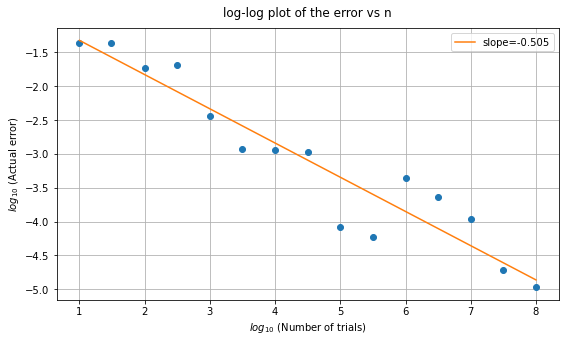

In [68]:
plot_error(n_values, errors, savepath)

(b) Choose $n=10^4$ and calculate $\sigma_n=<f^2>-<f>^2$. You should recognize that $\sigma_n$ is not a good estimate of the error:

In [54]:
_, f_2 = monte_carlo(10000, variance=True)
print(f_2) # much bigger than the actual error

0.22099618708203184


(c-d) To improve the error estimate, apply the following two different methods of variance reduction:

    -Average of the averages
    -Block averages

In [55]:
# Average of the averages
def avg_of_avgs(m, n):
    """
    Compute the average of the averages and the standard deviation of the average.
    
    Parameters:
    m (int): number of runs.
    n (int): number of points in each run.
    
    Returns:
    tuple: the average of m runs and its standard deviation.
    """
    M = []
    M_2 = []
    for i in range(m):
        M_a = monte_carlo(n, fix_seed=False) # the seed must change
        M.append(M_a)
        M_2.append(M_a**2)

    sigma_M = np.sqrt(sum(M_2)/m - (sum(M)/m)**2)
    return sum(M)/m, sigma_M

You should recognize that $\sigma_{m} \approx \sigma_{n}/\sqrt{n}$

In [56]:
%timeit avg_of_avgs(10, 10000) # profiling

7.24 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
_, sigma_m = avg_of_avgs(10, 10000)
_, sigma_n = monte_carlo(10000, variance=True)
print(sigma_m, sigma_n/np.sqrt(10000))

0.0021941760839760305 0.0022486374844614835


In [58]:
# Block averages:
def block_avg(s, n, fix_seed=False):
    """
    Compute the block averages
    
    Parameters:
    s (int): number of blocks.
    n (int): number of points the run.
    fix_seed (bool): if True, fix the seed for each run. Default is False.
    
    Returns:
    tuple: the average of m blocks and its standard deviation.
    """
    values = monte_carlo(n, fix_seed=False, block_avg=True)
    block_size = int(n / s)
    block_avgs = [np.mean(values[i:i+block_size]) for i in range(0, len(values), block_size)]
    block_avgs_2 = [avg**2 for avg in block_avgs]
    
    sigma_s = np.sqrt(sum(block_avgs_2)/s - (sum(block_avgs)/s)**2)
    
    return sum(block_avgs)/s, sigma_s/np.sqrt(s)

In [17]:
%timeit block_avg(10, 10000) #profiling

779 µs ± 6.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
# verify it doesn't change with the block size
for i in range(1,5):
    print(block_avg(10**i, 10000))

(0.7858110625565858, 0.0026311462951793623)
(0.7883559322145542, 0.002491753281954278)
(0.7877066372477551, 0.002172807166956664)
(0.7880696155690674, 0.002232020218008412)
